<h1><center>The best  leagues in Europe</center><h1>

The Champions League is a League played by the best teams in different European leagues,This league will compete for the best team in Europe that year,We will analyze the data to find out which teams and which national league teams perform better

In [546]:
import re
import py2neo as neo
import pandas as pd
import numpy as np
import random
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import random
from IPython.display import HTML
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext, Row
from pyspark.sql.types import *
import seaborn as sns
import folium
from geopy.geocoders import Nominatim

In [58]:
from pyspark import SparkContext
if 'sc' in globals():
    sc.stop()
sc = SparkContext(master="local", appName="First App")

<h3>Find the UEFA Champions League nodes for each year in the database,And each team's node<h3>

In [59]:
db=neo.Graph("neo4j+s://52d54f1d.databases.neo4j.io",
    auth=("neo4j","cUQmozgEst1IHWWMmbpPgPiRExkAYWk-qSZdKYcALwA"))
node_matcher = neo.NodeMatcher(db)
nodes_Teams=node_matcher.match("Teams")
nodes_Teams=list(nodes_Teams)
nodes_Cleagues=node_matcher.match("Champion league")
nodes_Cleagues=list(nodes_Cleagues)

In [403]:
Champions_list=[]
top4_list=[]
top8_list=[]
top16_list=[]


def clean_Null(list):
    while "" in list:
        list.remove("")
    return list    

def find_C_list(T_names):
    C_list=[]
    for T_name in T_names:
        for node in nodes_Teams:
            if T_name==node["name"]:
                C_list.append(node["country"])
    return C_list  

def find_C(T_name):
    for node in nodes_Teams:
        if T_name==node["name"]:
            return node["country"]

In [404]:
for n in range(0,8):
    top4_list=top4_list+find_C_list(clean_Null(nodes_Cleagues[n]["Semi-finals"].split("-")))
    top8_list=top8_list+find_C_list(clean_Null(nodes_Cleagues[n]["Quarter-finals"].split("-")))
    top16_list=top16_list+find_C_list(clean_Null(nodes_Cleagues[n]["Round of 16"].split("-")))
    Champions_list.append( find_C(nodes_Cleagues[n]["champion"] )   )
    

<h3>Use pyspark to process data,Construct DataFrame data<h3>

In [405]:
RDD_CP=sc.parallelize(Champions_list,4)
TopRDD4=sc.parallelize(top4_list,4)
TopRDD8=sc.parallelize(top8_list,4)
TopRDD16=sc.parallelize(top16_list,4)

RDD_CP = RDD_CP.map(lambda s: (s,1)).reduceByKey(lambda x,y : x + y)
TopRDD4 = TopRDD4.map(lambda s: (s,1)).reduceByKey(lambda x,y : x + y)
TopRDD8 = TopRDD8.map(lambda s: (s,1)).reduceByKey(lambda x,y : x + y)
TopRDD16 = TopRDD16.map(lambda s: (s,1)).reduceByKey(lambda x,y : x + y)

In [406]:
schema = StructType([StructField('country', StringType()), StructField('Number of teams', IntegerType())])
df8=sqlContext.createDataFrame(TopRDD8,schema)
df4=sqlContext.createDataFrame(TopRDD4,schema)
df16=sqlContext.createDataFrame(TopRDD16,schema)


In [407]:
schema = StructType([StructField('country', StringType()), StructField('Wins', IntegerType())])
df_CP=sqlContext.createDataFrame(RDD_CP,schema)

<h3>Display map information  TOP 16 <h3>

In [550]:
geolocator = Nominatim(user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.90 Safari/537.36") 
country=["England","Germany","Greece","Ukraine","Switzerland","Portuguesa","Spain","France","Italy","Belgium","Netherlands","Turkey","Russia"]

In [553]:
lon=[]
lat=[]
def get_loc(C_name):
    for c in C_name:
        location = geolocator.geocode(c)
        lon.append(location.longitude)
        lat.append(location.latitude)



In [555]:
get_loc(country)

In [556]:
n = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=3)
for i in range(0,len(country)):
   folium.CircleMarker(
      location=[lat[i], lon[i]],
      popup=df16.toPandas().iloc[i]['country'],
      radius=float(df16.toPandas().iloc[i]['Number of teams']),
      value=df16.toPandas().iloc[i]['Number of teams'],
      color='#69b3a2',
      fill=True,
      fill_color='#69b3a2'
   ).add_to(n)
n

<h3>Here to find the leagues that have won the championship, and  in the past 8 years and enter, the top 4, the top 8 and the top 16 league teams<h3>

In [408]:
df_CP.show()

+-------+----+
|country|Wins|
+-------+----+
|    ENG|   2|
|    GER|   1|
|    ESP|   5|
+-------+----+



In [409]:
df8.show()

+-------+---------------+
|country|Number of teams|
+-------+---------------+
|    GER|             12|
|    ENG|             15|
|    POR|              4|
|    FRA|              7|
|    ESP|             18|
|    ITA|              7|
|    NED|              1|
+-------+---------------+



In [410]:
df4.show()

+-------+---------------+
|country|Number of teams|
+-------+---------------+
|    ENG|              8|
|    GER|              5|
|    FRA|              3|
|    ESP|             12|
|    NED|              1|
|    ITA|              3|
+-------+---------------+



In [411]:
df16.show()

+-------+---------------+
|country|Number of teams|
+-------+---------------+
|    ENG|             27|
|    GER|             25|
|    GRE|              2|
|    UKR|              3|
|    SUI|              2|
|    POR|              7|
|    ESP|             27|
|    FRA|             12|
|    ITA|             15|
|    BEL|              2|
|    NED|              2|
|    TUR|              2|
|    RUS|              2|
+-------+---------------+



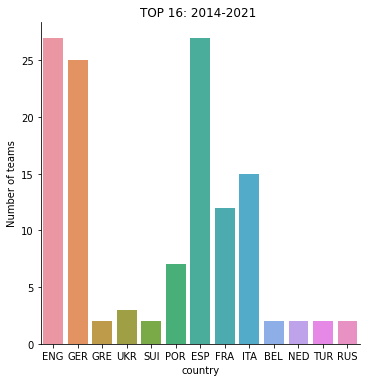

In [412]:
p=sns.catplot( y='Number of teams',x="country",kind="bar",data=df16.toPandas())
p.set(title = "TOP 16: 2014-2021 ")

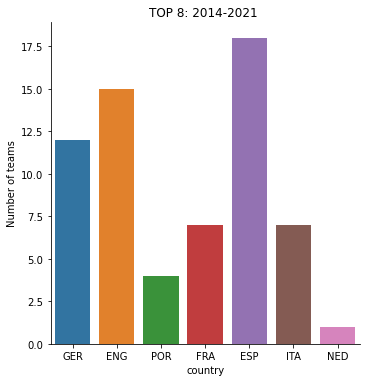

In [413]:
p=sns.catplot( y='Number of teams',x="country",kind="bar",data=df8.toPandas())
p.set(title = "TOP 8: 2014-2021 ")

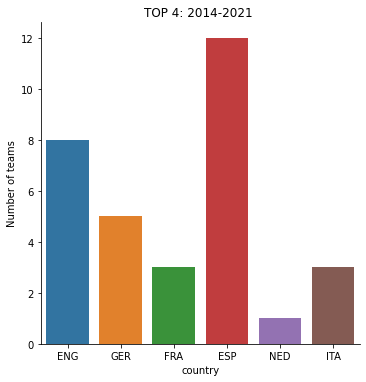

In [414]:
p=sns.catplot( y='Number of teams',x="country",kind="bar",data=df4.toPandas())
p.set(title = "TOP 4: 2014-2021 ")

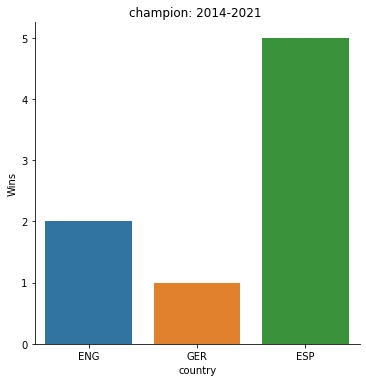

In [415]:
p=sns.catplot( y='Wins',x="country",kind="bar",data=df_CP.toPandas())
p.set(title = "champion: 2014-2021 ")

<h3>It can be seen from the Graphics and data above that the teams from Spain, Germany, and England have entered the finals and the top spots the most.<h3>

<h3>The following will analyze the number of wins and winning percentages of different leagues in the Champions League.<h3>

In [417]:
r_matcher = neo.RelationshipMatcher(db)
CL_teams=[]
CL_teams_nodes=[]
for n in range(0,8):
    R_1=r_matcher.match([nodes_Cleagues[n]],r_type="participate")
    R_1=list(R_1)
    for r in R_1:
        if r.end_node["name"] not in CL_teams:
            CL_teams.append(r.end_node["name"])
            CL_teams_nodes.append(node_matcher.match("Teams",name=r.end_node["name"]).first() )

CL_teams_nodes=list(CL_teams_nodes)

<h3>Find the teams node in the database, create a data list, and then use pyspark to process the data<h3>

In [419]:
Total_matches=[]
Win_matches=[]

for node in CL_teams_nodes:
    R_2=r_matcher.match([node],r_type="match")
    for r in R_2:
        Total_matches.append(r.start_node["country"]) 
        Total_matches.append(r.end_node["country"])
        if r["winner"]!=" X":
            Win_matches.append( find_C(r["winner"]))

In [422]:
Total_RDD=sc.parallelize(Total_matches,4)
WIn_RDD=sc.parallelize(Win_matches,4)

Total_RDD = Total_RDD.map(lambda s: (s,1)).reduceByKey(lambda x,y : x + y)
WIn_RDD = WIn_RDD.map(lambda s: (s,1)).reduceByKey(lambda x,y : x + y)
schema = StructType([StructField('country', StringType()), StructField('Matches', IntegerType())])
df_Total=sqlContext.createDataFrame(Total_RDD,schema)
df_WIn=sqlContext.createDataFrame(WIn_RDD,schema)

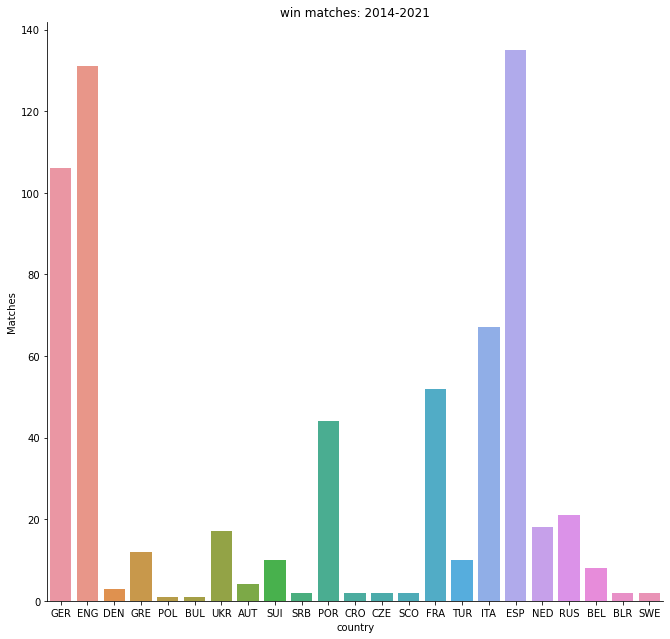

In [423]:
g= sns.catplot( y='Matches',x="country",kind="bar",data=df_WIn.toPandas())
g.fig.set_figwidth(10)
g.fig.set_figheight(9)
g.set(title = "win matches: 2014-2021")

In [424]:
RDD_winRate=WIn_RDD.join(Total_RDD)
new=[()]
for key, val in RDD_winRate.collect():
    new.append(  (key, int((round((val[0]/val[1]),2)*100)) )  )

del(new[0])

RDD_winRate=sc.parallelize(new,4)
schema = StructType([StructField('country', StringType()), StructField('Win rate', IntegerType())])
df_winRate=sqlContext.createDataFrame(RDD_winRate,schema)

In [425]:
df_winRate.show()

+-------+--------+
|country|Win rate|
+-------+--------+
|    GER|      50|
|    ENG|      52|
|    DEN|      17|
|    GRE|      30|
|    POL|      17|
|    BUL|      10|
|    UKR|      28|
|    AUT|      22|
|    SUI|      31|
|    SRB|      17|
|    POR|      39|
|    CRO|      11|
|    CZE|      12|
|    SCO|      12|
|    FRA|      40|
|    TUR|      20|
|    ITA|      42|
|    ESP|      59|
|    NED|      31|
|    RUS|      24|
+-------+--------+
only showing top 20 rows



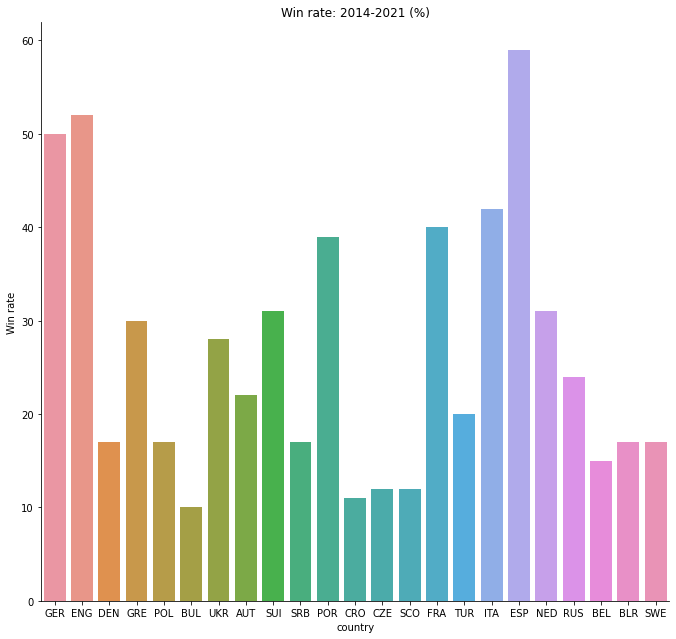

In [426]:
g= sns.catplot( y='Win rate',x="country",kind="bar",data=df_winRate.toPandas())
g.fig.set_figwidth(10)
g.fig.set_figheight(9)
g.set(title = "Win rate: 2014-2021 (%)")

<h3>The final conclusion drawn by analyzing the above data is that the teams from Spain, Germany, and England have performed the best in the Champions League in the past 8 years. Among them, Spain is the best, winning the Champions League 5 times and winning the Champions League. The number and winning percentage are also the best<h3>